# Project: Investigating Movie Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>


<a id='intro'></a>
## Introduction

>I have chose to use the TMDb dataset for my analysis. This dataset contains information from over 10,000 films pulled from the TMDb database, and it contains a wide range of information for each movie that includes financial data, production details, movie genres, and critical reception among other things.  

>There are so many questions that can be asked when investigating this dataset, but I will focus on four questions.  I will be looking to see if there are any variables that could potentially contribute to a higher voter rating, and I will be looking at the revenues, budget, month of release, production companies, actors, directors, genres, and run time to answer the following question:

>1. How are the different numerical variables distributed?
>2. Do any of the variables have correlations with vote_average?
>3. Are there differences in ratings in different months?
>4. What genre has the highest rating?

In [1]:
#import different packages for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> In this section of the report, the data is loaded and checked for cleanliness.  I then move on to trim and clean the dataset for analysis. 

### General Properties

In [2]:
#load the dataset and get a first look at the dataframe
df = pd.read_csv('tmdb-movies.csv')
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


#### We can see that the data has been imported.  Right off the bat I can see that some of the columns will need to be deleted, and some of the columns will need to be split into separate rows.

In [3]:
#identify different data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

#### Another thing to note is that the release_date column will need to be changed to a datetime data type.

In [4]:
#check for null values
df.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

#### There are quite a few null values that need to be addressed as well.

### Data Cleaning 
> There are several steps that need to be taken before being able to look at the relationship between the different variables and the user rating.  After assessing the data, we can see that some columns need to be dropped, some data in the columns needs to be split and moved to a separate row, and some null values need to be addressed.  The dataframe will also need to be sorted by different values to look at the relationships between the variables.  The following cells document this process. 


In [5]:
##remove columns that will not be used
df.drop(['production_companies', 'imdb_id', 'popularity', 'keywords', 'budget', 'revenue', 'homepage', 'tagline', 'overview', 'release_year'], axis = 1, inplace = True)
df.head(1)

,id,original_title,cast,director,runtime,genres,release_date,vote_count,vote_average,budget_adj,revenue_adj
0,135397,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,6/9/15,5562,6.5,1.379999e+08,1.392446e+09


#### We can see that several columns have been revoved that will not be factored into the analysis.

In [6]:
#drop null values
df.dropna(inplace = True)

#### To address the null values, I dropped them from the dataset.  We could have used the mean or median values to replace the null values, but the dataset is large enough that this is not necessary.

In [7]:
#confirm null values were dropped
df.isnull().sum()

id                0
original_title    0
cast              0
director          0
runtime           0
genres            0
release_date      0
vote_count        0
vote_average      0
budget_adj        0
revenue_adj       0
dtype: int64

#### We can see that the nulls have been dropped from the dataset.

In [8]:
#splitting the genres column into multiple columns 
#referred to this resource for splitting the columns into rows: https://programmer.ink/think/pandas-how-do-i-split-text-in-a-column-into-multiple-lines-python.html
split_col = ['genres', 'cast']

for col in split_col:
    df = df.drop(col, axis = 1).join(df[col].str.split('|', expand = True).stack().reset_index(level = 1, drop = True).rename(col))
df.head(1)

,id,original_title,director,runtime,release_date,vote_count,vote_average,budget_adj,revenue_adj,genres,cast
0,135397,Jurassic World,Colin Trevorrow,124,6/9/15,5562,6.5,1.379999e+08,1.392446e+09,Action,Chris Pratt


#### We can see that the cast and genres columns have been split into multiple rows.

#### This is a summary of the data.  This will help us add divide some of the variables into different classes and add them to new columns.

In [9]:
# sort by genre and save to a dataframe
genres = df.groupby(df['genres']).mean()
genres = genres.reset_index()
genres

,genres,id,runtime,vote_count,vote_average,budget_adj,revenue_adj
0,Action,47185.895407,105.918483,398.773082,5.805034,3.459645e+07,9.459723e+07
1,Adventure,44429.846227,106.427375,509.430306,5.921036,4.510776e+07,1.409027e+08
2,Animation,65172.523355,75.063009,370.764460,6.326466,3.232023e+07,1.082803e+08
3,Comedy,48171.474076,98.061744,201.103256,5.898757,1.907266e+07,5.661922e+07
4,Crime,45056.168046,107.101914,268.565866,6.096524,2.261355e+07,5.842044e+07
5,Documentary,115979.661005,100.132133,40.153193,6.897622,9.180000e+05,3.293299e+06
6,Drama,55101.864770,110.543471,194.651204,6.120157,1.686209e+07,4.526788e+07
7,Family,48205.100846,91.858130,306.903723,5.962798,3.070059e+07,1.000522e+08
8,Fantasy,44080.600572,101.031419,425.026131,5.853437,3.949370e+07,1.160812e+08
9,Foreign,31726.127133,108.021944,16.893069,5.925566,2.585174e+06,1.843471e+06


#### We now have a new data frame with mean values for each variable sorted by genre.

In [10]:
# change the data type of the release_date column to datetime 
df['release_date'] = pd.to_datetime(df['release_date'], format = '%m/%d/%y')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394256 entries, 0 to 10865
Data columns (total 11 columns):
id                394256 non-null int64
original_title    394256 non-null object
director          394256 non-null object
runtime           394256 non-null int64
release_date      394256 non-null datetime64[ns]
vote_count        394256 non-null int64
vote_average      394256 non-null float64
budget_adj        394256 non-null float64
revenue_adj       394256 non-null float64
genres            394256 non-null object
cast              394256 non-null object
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 36.1+ MB


#### We can see that the release_date has been changed to a datetime data type.

In [11]:
# extract month from release_date column 
# used the following link for help: https://www.interviewqs.com/ddi_code_snippets/extract_month_year_pandas
df['month'] = pd.DatetimeIndex(df['release_date']).month
df.head()

,id,original_title,director,runtime,release_date,vote_count,vote_average,budget_adj,revenue_adj,genres,cast,month
0,135397,Jurassic World,Colin Trevorrow,124,2015-06-09,5562,6.5,1.379999e+08,1.392446e+09,Action,Chris Pratt,6
0,135397,Jurassic World,Colin Trevorrow,124,2015-06-09,5562,6.5,1.379999e+08,1.392446e+09,Action,Bryce Dallas Howard,6
0,135397,Jurassic World,Colin Trevorrow,124,2015-06-09,5562,6.5,1.379999e+08,1.392446e+09,Action,Irrfan Khan,6
0,135397,Jurassic World,Colin Trevorrow,124,2015-06-09,5562,6.5,1.379999e+08,1.392446e+09,Action,Vincent D'Onofrio,6
0,135397,Jurassic World,Colin Trevorrow,124,2015-06-09,5562,6.5,1.379999e+08,1.392446e+09,Action,Nick Robinson,6


#### We have extracted the month from the release_date column and added it as a new column to sort by month later in the analysis.

In [12]:
# sort by a column
# help from: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
df_month = df.groupby(df['month']).mean().round(2)
df_month

,id,runtime,vote_count,vote_average,budget_adj,revenue_adj,month
month,,,,,,,
1,47602.83,101.03,162.15,5.81,9986382.28,2.640603e+07,1.0
2,47809.17,103.60,200.34,5.88,18735859.73,3.843826e+07,2.0
3,51885.05,103.58,280.75,5.91,22250149.10,6.597386e+07,3.0
4,47670.84,102.13,239.07,5.81,21325055.87,5.453006e+07,4.0
5,48061.62,108.27,402.74,5.94,33139312.99,1.073974e+08,5.0
6,46123.75,104.87,421.71,5.97,39118437.47,1.331402e+08,6.0
7,50696.04,103.13,394.04,5.88,32863317.85,1.026040e+08,7.0
8,57742.64,100.68,194.24,5.83,18696110.55,4.358289e+07,8.0
9,58841.49,103.64,192.66,6.06,15185905.45,3.145159e+07,9.0


#### A new dataframe has been created that is sorted by month and lists the mean value for each variable.

In [13]:
# get a statistical summary of the data 
df.describe()

,id,runtime,vote_count,vote_average,budget_adj,revenue_adj,month
count,394256.000000,394256.000000,394256.000000,394256.000000,3.942560e+05,3.942560e+05,394256.000000
mean,52328.615001,103.903981,276.823298,5.932459,2.441305e+07,6.955972e+07,6.837638
std,81322.046033,28.811005,681.012355,0.890308,4.125053e+07,1.733189e+08,3.425304
min,5.000000,0.000000,10.000000,1.500000,0.000000e+00,0.000000e+00,1.000000
25%,9945.000000,91.000000,19.000000,5.400000,0.000000e+00,0.000000e+00,4.000000
50%,16258.000000,100.000000,49.000000,6.000000,1.899489e+06,0.000000e+00,7.000000
75%,47474.000000,113.000000,196.000000,6.500000,3.349690e+07,5.708307e+07,10.000000
max,417859.000000,900.000000,9767.000000,9.200000,4.250000e+08,2.827124e+09,12.000000


#### This summary of the data will help create new columns that categorize the budget, revenue, and vote average variables.

In [14]:
# define a function that adds a class to the dataframe
def category(new_column, old_column):
    df[new_column] = pd.cut(df[old_column], bin_edges, labels = bin_names)

#### This function will allow us to create a new column in the dataframe to categorize different numerical variables.

In [15]:
# categorize as high, medium, or low budget films and store in a dataframe
bin_edges = [0, 1899489,33496900,425000000]
bin_names = ['high','medium', 'low']
category('budget_class', 'budget_adj') 
budget_class = df.groupby(df['budget_class']).mean()
budget_class = budget_class.reset_index()
budget_class

,budget_class,id,runtime,vote_count,vote_average,budget_adj,revenue_adj,month
0,high,72753.837255,94.504596,95.791758,5.779768,6.645848e+05,8.914406e+06,5.919679
1,medium,43028.509207,103.721198,216.311144,5.973453,1.563778e+07,4.735905e+07,6.741342
2,low,27786.248917,114.685172,790.768924,6.107002,8.210074e+07,2.180974e+08,7.285026


#### This new dataframe will be used to visualize the effects of budget on vote average.

In [16]:
# categorize as long, moderately-long, moderately-short, or short movies and store in a dataframe
bin_edges = [0, 91,100,113,900]
bin_names = ['Long','Moderately-Long','Moderately-Short', 'Short']
category('length', 'runtime')
length = df.groupby(df['length']).mean()
length = length.reset_index()
length

,length,id,runtime,vote_count,vote_average,budget_adj,revenue_adj,month
0,Long,72283.548694,80.832908,116.459693,5.676421,1.045220e+07,2.825537e+07,6.701555
1,Moderately-Long,52614.906958,95.928172,183.395358,5.726739,1.822173e+07,4.561381e+07,6.545429
2,Moderately-Short,42594.599797,106.373951,265.944668,6.018104,2.480714e+07,6.265464e+07,6.812523
3,Short,39049.456065,135.155720,556.596295,6.336007,4.553016e+07,1.455300e+08,7.297776


#### This dataframe will be used to visualize the effects of runtime on vote average.

In [17]:
# categorize as high or low revenue movies and store in a dataframe
bin_edges = [0, 57083070,2827124000]
bin_names = ['High','Low']
category('revenue_class', 'revenue_adj')
revenue_class = df.groupby(df['revenue_class']).mean()
revenue_class = revenue_class.reset_index()
revenue_class

,revenue_class,id,runtime,vote_count,vote_average,budget_adj,revenue_adj,month
0,High,43089.202051,103.946768,145.285003,5.949858,1.931194e+07,1.901510e+07,6.713000
1,Low,29527.869071,113.439617,871.665658,6.282492,6.945834e+07,2.597543e+08,7.200784


#### This dataframe will be used to show the effects of revenue on runtime.

<a id='eda'></a>
## Exploratory Data Analysis



### 1. How are the different numerical features distributed?

Knowing the distribution of each will be able to help us determine if there are any features that have extreme outliers that need to be manipulated.

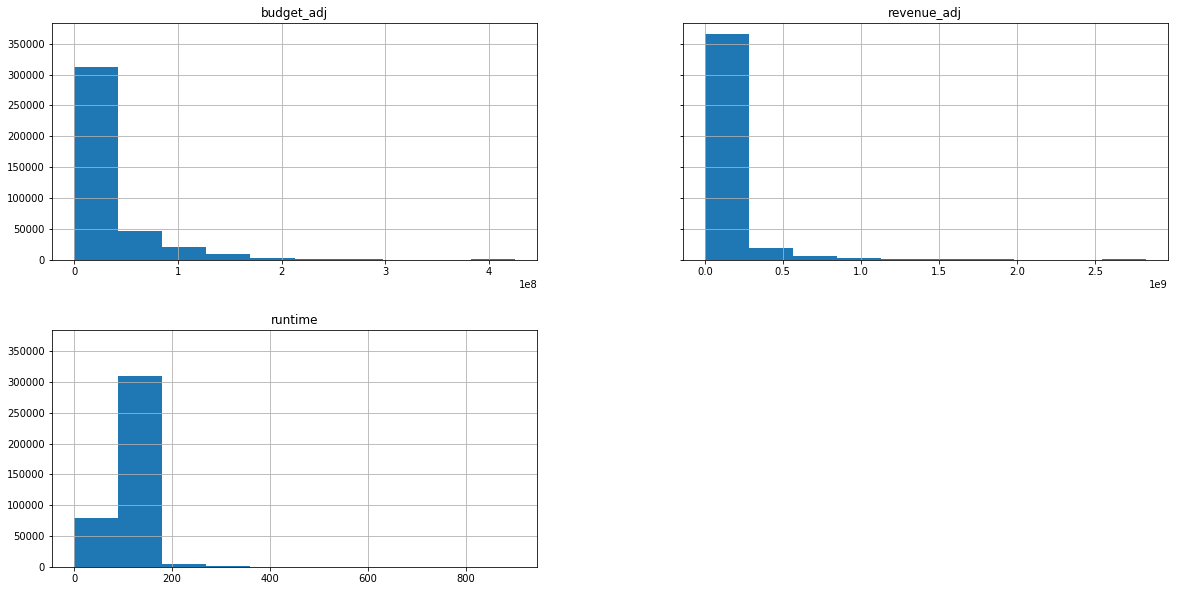

In [18]:
#create a histogram for each variable to show its distribution 
df.hist(column = ['runtime', 'budget_adj', 'revenue_adj'], sharey = True, figsize = (20,10));

#### Each of these subplots represents a single variable exploration of 3 different features. We can see that the 3 features above are skewed to the right suggesting that there are outliers in the data.  This suggests that we may need to remove or manipulte further some of the data if we are making a regression line to predict voter rating.

### 2. Do any of the features have correlations with vote_average?

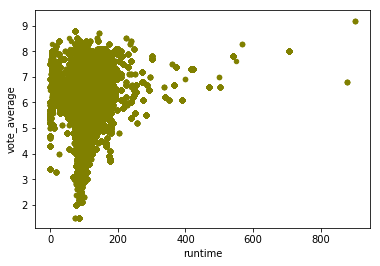

In [19]:
# scatterplot of runtime vs. vote average
df.plot(x = 'runtime', y = 'vote_average', kind = 'scatter', color = 'olive');

#### The scatterplot above indicates that there is not a strong correlation between vote_average and runtime.

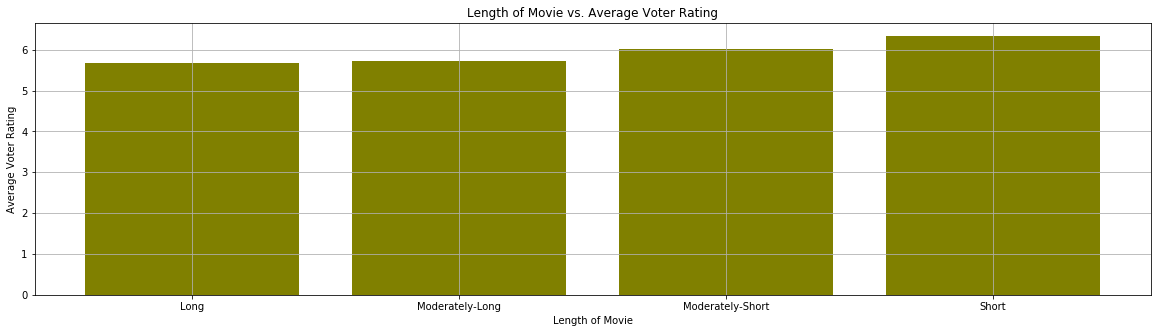

In [20]:
# bar chart showing statistical summary of length vs rating
plt.figure(figsize = (20,5))
plt.grid()
plt.bar(length['length'], length['vote_average'], color = 'olive', width = .8)
plt.xlabel('Length of Movie')
plt.ylabel('Average Voter Rating')
plt.title('Length of Movie vs. Average Voter Rating');

#### The graphs shows a trend that the shorter the movie, the higher the average vote is.  

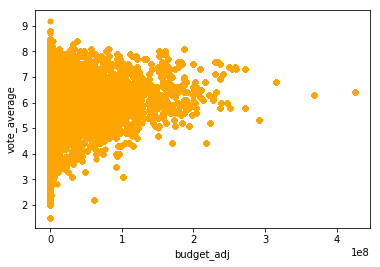

In [21]:
# scatterplot of adjusted budget vs. vote average
df.plot(x = 'budget_adj', y = 'vote_average', kind = 'scatter', color = 'orange');

#### The scatterplot above indicates that there is not a strong correlation between vote_average and budget.

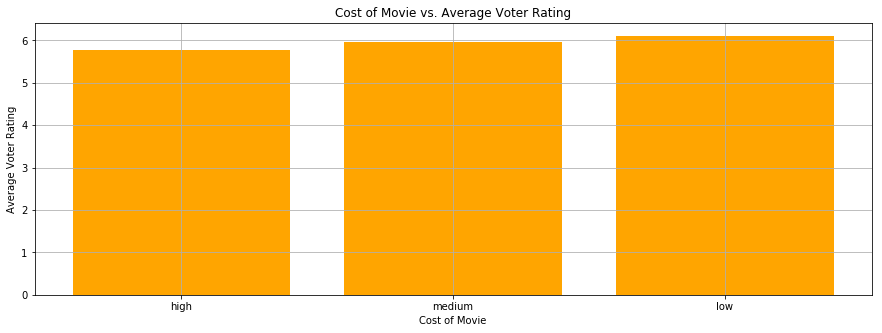

In [22]:
# bar chart showing statistical summary of budget vs rating
plt.figure(figsize = (15,5))
plt.grid()
plt.bar(budget_class['budget_class'], budget_class['vote_average'], color = 'orange', width = .8)
plt.xlabel('Cost of Movie')
plt.ylabel('Average Voter Rating')
plt.title('Cost of Movie vs. Average Voter Rating');

#### The graphs shows a trend that the more expensive the movie, the higher the average vote is.  

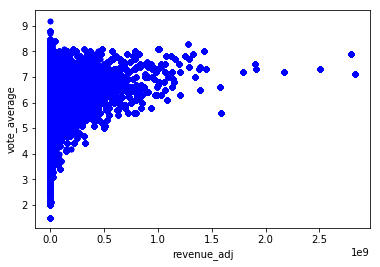

In [23]:
# scatterplot of adjusted revenue vs. vote average
df.plot(x = 'revenue_adj', y = 'vote_average', kind = 'scatter', color = 'blue');

#### The scatterplot above indicates that there is not a strong correlation between vote_average and budget.

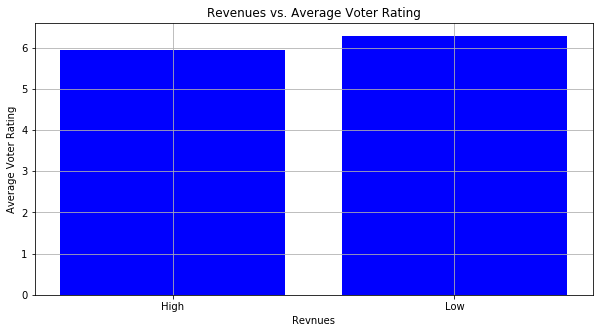

In [24]:
# bar chart showing statistical summary of revenues vs rating
plt.figure(figsize = (10,5))
plt.grid()
plt.bar(revenue_class['revenue_class'], revenue_class['vote_average'], color = 'blue', width = .8)
plt.xlabel('Revnues')
plt.ylabel('Average Voter Rating')
plt.title('Revenues vs. Average Voter Rating');

#### The graphs shows a trend that the more revenues the movie brings in, the higher the average vote is.  

### It does not appear that there is a strong linear relationship between the three numerical variables and voter rating.


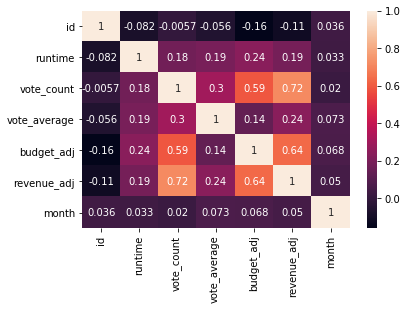

In [25]:
#correlation matrix for the different variables in the dataframe
#used seaborn to make heatmap: https://seaborn.pydata.org/generated/seaborn.heatmap.html
correlation = df.corr()
correlation = sns.heatmap(correlation, annot = True)
correlation;

#### Looking at the table above, we can see that vote_average has a low correlation with runtime, budget_adj, and revenue_adj.  This indicates that these variables may not individually contribute much to the user's opinion.  Further tests are required to determine if together they are good variables to predict user opinion.

### 3. Are there differences in ratings in different months?

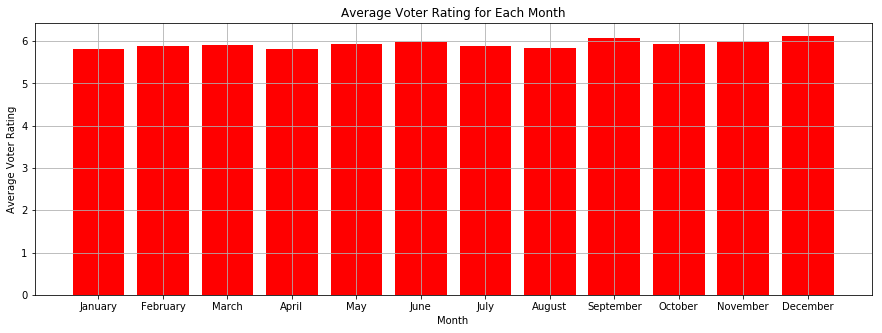

In [26]:
# bar chart of average rating for each month
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.figure(figsize = (15,5))
plt.grid()
plt.bar(months, df_month['vote_average'], color = 'red', width = .8)
plt.xlabel('Month')
plt.ylabel('Average Voter Rating')
plt.title('Average Voter Rating for Each Month');

#### The graph above shows that December has the highest average vote.  

### 4. What genre has the highest rating?

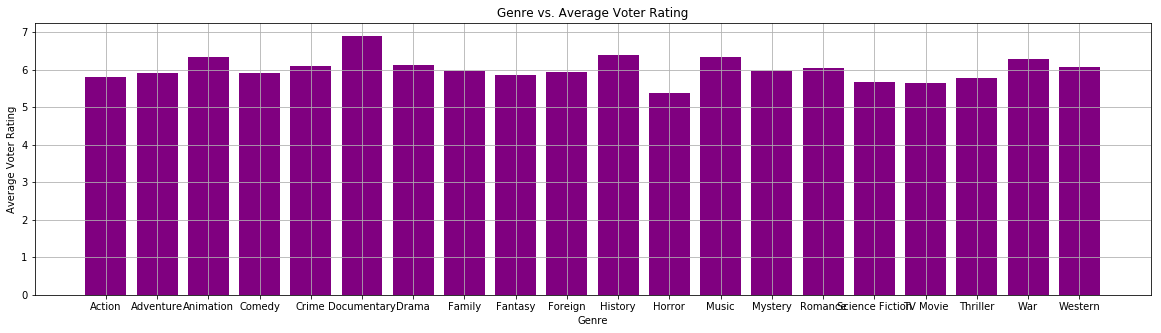

In [27]:
#bar chart showing genre
plt.figure(figsize = (20,5))
plt.grid()
plt.bar(genres['genres'], genres['vote_average'], color = 'purple', width = .8)
plt.xlabel('Genre')
plt.ylabel('Average Voter Rating')
plt.title('Genre vs. Average Voter Rating');

#### Looking at this graph, it appears that December has the highest average rating.  The cause of this could be many things, and more tests are needed to identify what they are.

<a id='conclusions'></a>
## Conclusions

> One thing to note above is that there seems to be a correlation between the voter rating and three of the variables.  Looking at the graph titled "Length of Movie vs. Average Voter Rating", we can see that the longer the movie is, the lower the average rating.  Looking at the graph titled "Cost of Movie vs. Average Voter Rating", we can see that the lower budget movies had the highest average rating.  Looking at the graph titled "Revenues vs. Average Voter Rating" we can see that lower revenues are linked to higher average rating.  There could be several reasons that this could happen, and more tests need to be done to determine if this is just a correlation or if these variables actually cause the voter to trend the way it does in those graphs. Another conclusion to make is that it appears that December has the highest average voter rating.  Another thing to note is that documentaries have the highest average rating.

<a id='conclusions'></a>
### Limitations

> The main limitation of this analysis is that it only identifies trends, and it does not identify the cause of the trend.  For example, we can see that movies released in December receive the highest average rating, but we do not know if that is because the movie was released in December, because people were happier due to the holiday season, or for some other reason.  Another limitation is that I may have deleted some of the columns that contribute to a high voter rating.  Cast, director, and production company could also factor in.  This analysis is only descriptive, and inferences should not be made.